In [1]:
from utils_svm_reviews import *
from collections import Counter
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Load and Shuffle the Data

In [3]:
data = load_and_shuffle_data()

In [4]:
# full text from 2000 movies reviews: 1000 reviews are classified as positive and 1000 as negative. 
len(data) 

2000

In [5]:
# label
data[0][-1] 

-1

In [6]:
len(data[0])

454

In [7]:
len(data[100])

486

# Q5

- Write a function that converts an example (a list of words) into a sparse bag-of-words representation. You may find Python’s Counter3 class to be useful here. Note that a Counter is itself a dictionary.

In [8]:
def construct_word_dict(lst_of_words):
    """
    convert the given list of words into a sparse bag-of-words representation
    """
    dict_of_words = Counter(lst_of_words)
    
    return dict_of_words


In [9]:
# construct_word_dict(data[0][:-1])

# Q6

- Load all the data and split it into 1500 training examples and 500 validation examples. Format the training data as a list X train of dictionaries and y train as the list of corre- sponding 1 or -1 labels. Format the test set similarly.

In [10]:
class review:
    def __init__(self, lst_of_words_):
        self.lst_of_words = lst_of_words_[:-1]
        self.dict_of_words = Counter(self.lst_of_words)
        self.label = lst_of_words_[-1]

In [11]:
X_train_lst_of_reviews = list(map(review, data[:1500]))
X_val_lst_of_reviews = list(map(review, data[1500:2000]))

In [12]:
X_train = [review.dict_of_words for review in X_train_lst_of_reviews]
X_val = [review.dict_of_words for review in X_val_lst_of_reviews]

In [13]:
y_train = [review.label for review in X_train_lst_of_reviews]
y_val = [review.label for review in X_val_lst_of_reviews]

In [14]:
len(X_train)
len(X_val)

1500

500

# Q7

In [15]:
def pegasos_algorithm(lst_of_reviews, epoch, lamb):
    # initialization
    np.random.seed(9)
    
    weight = Counter()
    iter_num = 0
    epoch_ = 1
    
    while epoch_ <= epoch:
        shuffled_lst_of_reviews = np.random.choice(list(range(len(lst_of_reviews))), len(lst_of_reviews), replace=False)
        for j in shuffled_lst_of_reviews:
            iter_num += 1
            eta = 1.0 / (iter_num * lamb)
            increment(weight, - eta * lamb, weight)
            condition = lst_of_reviews[j].label * dotProduct(lst_of_reviews[j].dict_of_words, weight)
            if condition < 1:
                increment(weight, eta * lst_of_reviews[j].label, lst_of_reviews[j].dict_of_words)
        epoch_ += 1
    return weight


# Q8

In [16]:
def pegasos_algorithm_fast(lst_of_reviews, epoch, lamb):
    # initialization
    np.random.seed(9)
    
    weight = Counter()
    s = 1
    iter_num = 1
    epoch_ = 1
    
    while epoch_ <= epoch:
        shuffled_lst_of_reviews = np.random.choice(list(range(len(lst_of_reviews))), len(lst_of_reviews), replace=False)
        for i in shuffled_lst_of_reviews:
            iter_num += 1
            eta = 1.0 / (iter_num * lamb)
            condition = lst_of_reviews[i].label * dotProduct(lst_of_reviews[i].dict_of_words, weight) * s
            s = (1 - eta * lamb) * s
            if  condition < 1:
                increment(weight, eta * lst_of_reviews[i].label / s, lst_of_reviews[i].dict_of_words)
        epoch_ += 1 
        
    epoch_weight = Counter()      
    increment(epoch_weight, s, weight)

    return epoch_weight


# Q9

In [17]:
lamb_ = 0.01
epoch = 5
        
start = time.time()
weight_ = pegasos_algorithm(X_train_lst_of_reviews, epoch, lamb_)
end = time.time()
print('epoch:' + str(epoch) + 'pegasos_algorithm run time:' + str(end-start))

start = time.time()
weight_fast = pegasos_algorithm_fast(X_train_lst_of_reviews, epoch, lamb_)
end = time.time()
print('epoch:' + str(epoch) + 'pegasos_algorithm_fast run time:' + str(end-start))

increment(weight_, -1, weight_fast)
sqr_diff = dotProduct(weight_, weight_)
print("The square difference between the weight of pegasos_algorithm and the weight of pegasos_algorithm_fast is: "+ str(sqr_diff))


epoch:5pegasos_algorithm run time:70.50635290145874
epoch:5pegasos_algorithm_fast run time:0.7125890254974365
The square difference between the weight of pegasos_algorithm and the weight of pegasos_algorithm_fast is: 1.1139925353372174e-05


# Q10

In [18]:
def sign(review_dict_of_words, weight):
    if dotProduct(review_dict_of_words, weight) > 0:
        return 1
    else:
        return -1
        
def classification_error(weight, lst_of_reviews):
    predict_true = [sign(review.dict_of_words, weight) != review.label for review in lst_of_reviews]
    
    return sum(predict_true)/len(predict_true)


# Q11

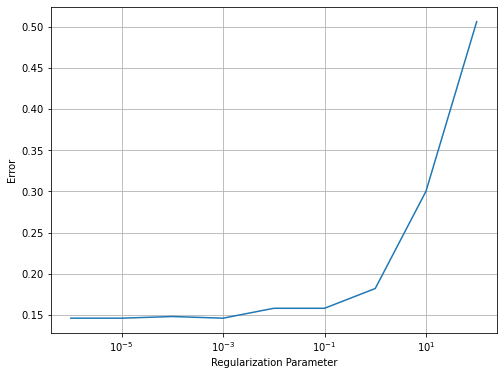

In [19]:
param_lst = [10 ** n for n in range(-6, 3)]
weight_list = []
percent_err_list = []
for lamb_ in param_lst:
    weight_ = pegasos_algorithm_fast(lst_of_reviews=X_train_lst_of_reviews, epoch=100, lamb=lamb_)
    weight_list.append(weight_)
    per_err = classification_error(weight=weight_, lst_of_reviews=X_val_lst_of_reviews)
    percent_err_list.append(per_err)

# Q12

In [39]:
# calculate the mean score for each group
weight_ = pegasos_algorithm_fast(lst_of_reviews=X_train_lst_of_reviews, epoch=100, lamb=0.001)
y_predict = []
for reivew in X_val_lst_of_reviews:
    y_predict.append(dotProduct(reivew.dict_of_words, weight_))
    

In [86]:
bin_size = 5
group_num = int(len(y_predict)/bin_size)
y_predict_group = np.array_split(y_predict, bin_size)
group_mean_score = []
group_per_error = []
group_index = 0
for group in y_predict_group:
    group_mean_score.append(np.mean(group))
    group_per_error.append(classification_error(weight=weight_, \
                                                lst_of_reviews=X_val_lst_of_reviews[group_num*group_index:\
                                                                                    group_num*(group_index+1)]))
    group_index += 1

In [87]:
rank_index_lst = list(np.array(group_mean_score).argsort()) # ascending
group_per_error_rank = [group_per_error[index] for index in rank_index_lst]
group_mean_score_rank = np.sort(group_mean_score)

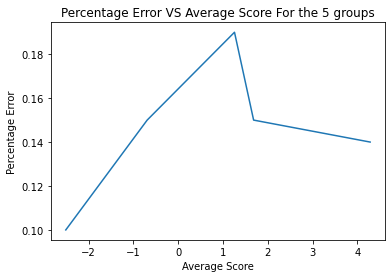

In [90]:
plt.plot(group_mean_score_rank, group_per_error_rank)
plt.title(f'Percentage Error VS Average Score For the {bin_size} groups')
plt.xlabel('Average Score')
plt.ylabel('Percentage Error')
plt.show();